## Analysis of Document Scores per Sentence

Experiment:

* Train a learner on 200 documents (bootstrap, balanced?)

* Pick 100 random documents and print for each:
    * Label
    * for each sentence print student score ($\max_y P_S(y|s)$) and text 
  

In [10]:
STRUCTURED = '/Users/maru/MyCode/structured'
DATA='/Users/maru/MyCode/data/imdb'
import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))

In [7]:
import utilities.experimentutils as exputil
import learner
import utilities.datautils as datautil
import numpy as np
import experiment.base as exp
import nltk

In [8]:
# Set random seed.
rnd = np.random.RandomState(2345)

In [18]:
from nltk import RegexpTokenizer
from nltk.stem import PorterStemmer

def stemming(doc):    

    wnl = PorterStemmer()
    mytokenizer = RegexpTokenizer('\\b\\w+\\b')

    return [wnl.stem(t) for t in mytokenizer.tokenize(doc)]

In [20]:
stemming('steming something else')

[u'steme', u'someth', u'els']

In [22]:
# Read data (optionally from a pickled file if present)
import os
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

DATA_PKL = DATA + '/data4.pkl'

if os.path.isfile(DATA_PKL):
    vct, data = pickle.load(open(DATA_PKL, 'rb'))
else:
    vct =  CountVectorizer(encoding='ISO-8859-1', min_df=5, max_df=1.0, binary=True, ngram_range=(1, 3),
                      token_pattern='\\b\\w+\\b', tokenizer=stemming)
    data = datautil.load_dataset('imdb', DATA, categories=None, rnd=5463, shuffle=True)
    data.train.data = np.array(data.train.data, dtype=object)
    data.test.data = np.array(data.test.data, dtype=object)
    data.train.bow = vct.fit_transform(data.train.data)
    data.test.bow = vct.transform(data.test.data)
    pickle.dump((vct, data), open(DATA_PKL, 'wb'))

In [23]:
data.train.bow.shape

(24991, 267154)

In [20]:
# Select the bootstrap.
data.train.remaining = rnd.permutation(len(data.train.target))
initial = rnd.choice(data.train.remaining, 200, replace=False)

# Select N random testing documents
n = 100
rnd_docs = list(set(data.train.remaining) - set(initial))
rnd.shuffle(rnd_docs)
print len(rnd_docs), rnd_docs[:10]

24800 [19538, 24317, 4219, 10821, 23384, 20565, 17820, 17786, 14727, 11906]


In [21]:
# Initialize and fit the expert.
expert = exputil.get_classifier('lrl2',parameter=1)
expert.fit(data.train.bow, data.train.target)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [22]:
# Initialize the student.
reload(learner.strategy)
clf = exputil.get_classifier('lrl2',parameter=1)
st = learner.strategy.StructuredLearner(clf)
sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
st.set_sent_tokenizer(sent_tk)
st.set_vct(vct)
st.set_snippet_utility('sr')
st.set_calibration(True)

In [23]:
# Train the student.
st.fit(data.train.bow[initial], data.train.target[initial], doc_text=data.train.data[initial])

In [24]:
# Split testing documents into sentences.
sent = sent_tk.tokenize_sents(data.train.data[rnd_docs[:n]])

In [25]:
# Select best snippet for each document.
sent_scores, snippet_text = st._compute_snippet(data.train.data[rnd_docs[:n]])

In [51]:
# Check classifier's calibration.
def score_sentences(st, sent, doc_labels):
    scores = []
    true_labels = []
    for sentences, doc_label in zip(sent, doc_labels):
        scores.extend([x[1] for x in st.snippet_model.predict_proba(vct.transform(sentences))])
        true_labels.extend([doc_label] * len(sentences))
    return np.array(scores), np.array(true_labels)
        
sent_scores, sent_labels = score_sentences(st, sent, data.train.target[rnd_docs[:n]])

predicted= [0, 0.1703198, 0.26188648, 0.361359, 0.45503461, 0.54475313, 0.63844258, 0.72915399, 0, 0] 
truth  = [0, 0.0, 0.12903225, 0.28368795, 0.45161289, 0.56955379, 0.77884614, 0.875, 0, 0]


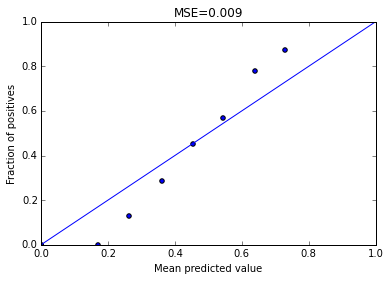

In [92]:
import matplotlib.pyplot as plt

def reliability_values(posteriors, labels, nbins):
    """ Compute reliability diagram values given posterior probabilities and true
    labels (0/1).
    >>> x, y = reliability_values([0.02, .11, .17], [0, 0, 1])
    >>> x
    [0.02, 0.14, 0, 0, 0, 0, 0, 0, 0, 0]
    >>> y
    [0.0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
    """
    
    predicted = np.zeros(nbins, 'f')
    truth = np.zeros(nbins, 'f')
    counts = np.zeros(nbins, 'f')
    for posterior, label in zip(posteriors, labels):
        idx = int(posterior * nbins)
        predicted[idx] += posterior
        truth[idx] += label
        counts[idx] += 1.
    predicted = [p / c if c != 0 else 0 for p, c in zip(predicted, counts)]
    truth = [p / c if c != 0 else 0 for p, c in zip(truth, counts)]
    return predicted, truth

def plot_reliability_diagram(posteriors, labels, nbins=10):
    """ Create reliablity plot
    """
    x, y = reliability_values(posteriors, labels, nbins)
    print 'predicted=', x, '\ntruth  =', y
    plt.figure()
    plt.scatter(x, y)
    diag = np.arange((nbins + 1)) / nbins
    plt.plot(diag, diag)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    err = np.mean([(xi - yi) * (xi - yi) for xi, yi in zip(x, y)])
    plt.title('MSE=%.3f' % err)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
plot_reliability_diagram(sent_scores, sent_labels, 10)